## Splic3r Demo

Splic3r is a python tool for the insertion of custom G-Code within pre-existing sliced files for the creation of 3D printed interactive devices with embedded printed circuit boards (PCBs).

This is part of the Printegrated Circuits project, an academic demonstration of how a 3D printer can be used to make interactive parts with robust electrical connections between those parts and traditional PCB-based electronics. This demonstration is by no means ready for general use and is very rough around the edges. It should be taken as a proof-of-concept to guide others who wish to implement this kind of functionality in their own design flows rather than deployable tool.

Currently it only works with the Prusa XL with files sliced by Prusa Slicer, a toolchanging 3d printer. It may be possible to modify this code to work with other printers, but toolchanging is still a non-standard process in 3-D printing, and requires different preinter-specific G-code commands to make it work.

In this notebook we walk though the generation and insertion of custom G-code to create the electrical connections in these parts.

This guide will take you though all the steps needed to design and insert functional electronics into your 3D Prints:
- Electronics Design
- Board export
- 3D Modelling
- printerconnection Usage
- G-code insertion
- Printing Process

This was tested with files produced with PrusaSlicer2.7.4 and Printed on a 5-tool Prusa XL running firmware version 6.0.0

## Step 1 - Electronics Design

Printegrated circuits are fully embedded PCBs in 3D printed parts. The first step of designing a piece of 3D printed interactive hardware is therefore to have a circuit board to design around. You can either design your own PCB, or use an existing one. In the board library, we have a demo project. You can also design your own or import the design files into KICAD and use our plugin to export the right design files to complete the process.

When designing boards consider:
- Only placing components on one side so that the toolhead does not collide with the print
- Ensuring parts don't protrude off the edge of the board which make part insertion fiddly
- Maximize hole spacing - try to avoid holes less than 2.54mm apart

## Step 2 - Board File Export

### PCB STEP File
from PCB Editor: File > Export > Step... Then use default export parameters

### Drill Files
From PCB Editor: Click the plotter icon, select "Generate Drill Files", then "Generate Drill File" in the new dialogue. Finally close both files.
PTH drill file for generating custom moves

In the Export directory, by default this is just the porject directory, you should now see a {project_name}-PTH.drl and a {project_name}-NPTH.drl. We're interested in the PTH (Plated Though Hole). This is the file that specifies to the drilling machine where to drill holes that will be plated with copper. We want this because it tells us the relative positions of holes are that we want to fill 

## Step 3 - 3D Modelling
We want this process to be agnostic to modelling software for a number of reasons:
- There exist projects that already insert electrodes and traces into 3d printed parts such as TODO: find capricate and other tools
- Different applications need different design tools
- By choosing one or creating our own we are limiting the scope of what might be possible with this toolset
- Board layout needs to line up with bottom layer


## Step 4 -Slicing
- TODO: Get INI file
- Use Prusa Slicer 2.7.4
- TODO: Find printer firmware version
- No Bgcode

## Step 5 - Splic3r Usage 

This is really multiple steps. We've chosen to present the flow as a ipython notebook, so that people who wish to use the tool can get a better understanding of what's going on. The code only works for very specific examples for the time being, so opening it up in this way lets people understand what might be going wrong if they aren't getting the output thy expected.

Before we start, we specify which files we'll be working on

**drl** is the drill file for plated though holes (PTH) generated by KICAD. Normally it's for describing to a milling machine where to drill holes, but here we're using it to extract the coordinates of where to inject filament

**in_gcode** is the output from the previous step

**out_gcode** is where we want the final file

In [60]:
drl = "../Characterisation/Characterisation_board_demo/Characterisation Board-PTH.drl"
in_gcode = "../Characterisation/4 Point/First/4point.gcode"
out_gcode = "../Characterisation/4 Point/First/out.gcode"

In [61]:
import numpy as np
import splic3r.gcode
import splic3r.drl
from importlib import reload
reload(splic3r.gcode)

<module 'splic3r.gcode' from '/mnt/c/Users/Oliver/OneDrive - University of Bristol/PhD/Print-and-Place/printerconnect/splic3r/gcode.py'>

In [62]:
## Parse various data from the gcode file
gcode = splic3r.gcode.GCode.from_file(in_gcode)

In [63]:
## We're going to generate a list printer moves so we can plot them
max_layers = gcode.lines[-1].state.layer
layers = []
for layer in range(1, max_layers+1):
    # get all the lines where the layer number is right
    lines = [line for line in gcode.lines if line.state.layer == layer]
    paths = []
    extruding = False
    for i, line in enumerate(lines):
        if line.state.extruding:
            if not extruding:
                paths.append(([lines[i-1].state.current_position]))
            paths[-1].append(line.state.current_position)
            extruding = True
        else:
            extruding = False
    layers.append(list(map(np.array, paths)))

In [64]:
## Calculate the bounding box of all the printer moves
min_path_coords = np.array([np.inf, np.inf, np.inf])
max_path_coords = np.array([-np.inf, -np.inf, -np.inf])

for layer in layers:
     for path in layer:
         for point in path:
                min_path_coords = np.minimum(min_path_coords, point)
                max_path_coords = np.maximum(max_path_coords, point)

path_midpoint = (min_path_coords + max_path_coords) / 2

In [65]:
drill_file = splic3r.drl.DrillFile.from_file(drl)


holes = drill_file.drills['T1']
holes_array = np.array(holes)

# Calculate the midpoint using NumPy
min_holes_coords = holes_array.min(axis=0)
max_holes_coords = holes_array.max(axis=0)
hole_midpoint = (min_holes_coords + max_holes_coords) / 2

In [66]:
## A Class for the plot to keep track of the splice state

class Splice:
    def __init__(self, layers):
        self.layer_num = 1
        self.layers = layers
        self.max_layer = len(layers)
        self.hole_offset = np.array([0,0])
        self.plot_offset = np.array([0,0])
        self.mirrored = False
    

splice = Splice(layers)

splice.hole_offset = path_midpoint[:2] - hole_midpoint

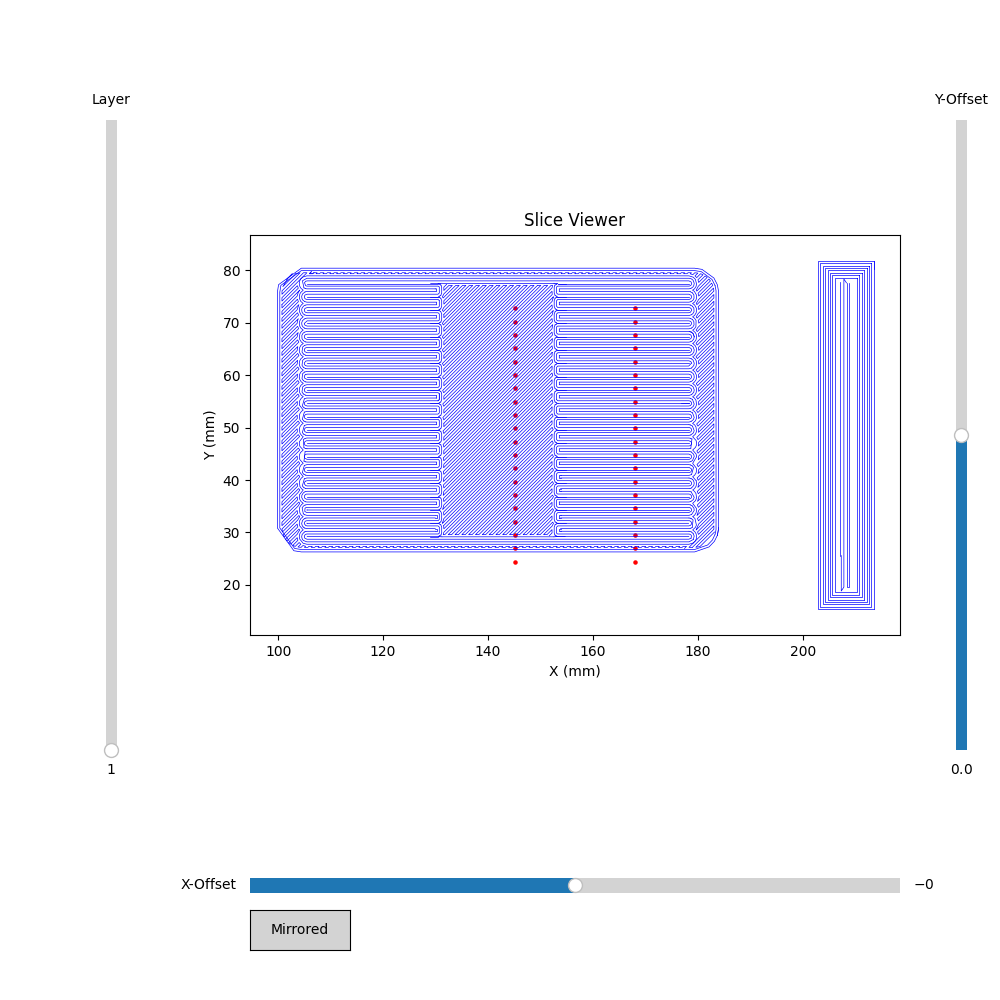

In [67]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
%matplotlib widget


last_layer = splice.layer_num

fig, ax = plt.subplots(figsize=(10, 10))
fig.subplots_adjust(left=0.25, bottom=0.25)
ax.set_aspect('equal', adjustable='box')
plt.title('Slice Viewer')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')

# Set the plot area to be +-5 of the min and max path coordinates
min_x = min_path_coords[0] - 5
max_x = max_path_coords[0] + 5
min_y = min_path_coords[1] - 5
max_y = max_path_coords[1] + 5
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

## Pre-plot all the paths, just set them to be invisible
layer_plots = []
for layer in splice.layers:
    layer_plot = []
    for path in layer:
        if len(path) > 0:
            path = np.array(path)
            plot_lines = ax.plot(path[:,0], path[:,1], color='blue', linewidth=0.5, visible=False)
        layer_plot.append(plot_lines)
    layer_plots.append(layer_plot)

# Make a vertically oriented slider
axlayer = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
layer_slider = Slider(
    ax=axlayer,
    label="Layer",
    valmin=1,
    valmax=splice.max_layer,
    valinit=splice.layer_num,
    valstep=1,  # Set the step size to 1 for discrete integer intervals
    orientation="vertical"
)

# The function to be called anytime a slider's value changes
def update_layer(val):
    global last_layer
    splice.layer_num = int(val)
    last_layer_plot = layer_plots[last_layer-1]
    for line in last_layer_plot:
        for l in line:
            l.set_visible(False)
    layer_plot = layer_plots[val-1]
    for line in layer_plot:
        for l in line:
            l.set_visible(True)
    last_layer = val

layer_slider.on_changed(update_layer)
update_layer(splice.layer_num)

holes_scatter = None

def flip(points, midpoint):
    # only flip in x-axis
    return np.array([[point[0], midpoint[1] - (point[1] - midpoint[1])] for point in points])

def scatter_holes():
    global holes_scatter
    if holes_scatter is not None:
        holes_scatter.remove()
    flipped = flip(holes_array, hole_midpoint) if splice.mirrored else holes_array
    transformed_holes = flipped + splice.hole_offset + splice.plot_offset
    holes_scatter = ax.scatter(transformed_holes[:,0], transformed_holes[:,1], color='red', s=5, zorder=1)

scatter_holes()

x_lims = ax.get_xlim()
y_lims = ax.get_ylim()

x_range = x_lims[1]-x_lims[0]
y_range = y_lims[1]-y_lims[0]


# Add a horizontally oriented slider for the X offset
x_offset_ax = fig.add_axes([0.25, 0.1, 0.65, 0.03])
x_offset_slider = None

# Add a vertically oriented slider for the Y offset
y_offset_ax = fig.add_axes([0.95, 0.25, 0.0225, 0.63])
y_offset_slider = None

# The function to be called anytime the slider's value changes
def update_offset(val):
    splice.plot_offset = np.array([x_offset_slider.val, y_offset_slider.val])
    scatter_holes()
    fig.canvas.draw_idle()

def draw_sliders():
    global x_offset_slider, x_offset_ax, y_offset_slider, y_offset_ax
    if x_offset_slider is not None:
        x_centre = x_offset_slider.val
    else:
        x_centre = 0
    
    if y_offset_slider is not None:
        y_centre = y_offset_slider.val
    else:
        y_centre = 0

    x_lims = ax.get_xlim()
    y_lims = ax.get_ylim()
    x_range = x_lims[1]-x_lims[0]
    y_range = y_lims[1]-y_lims[0]
    
    x_offset_ax.clear()
    x_offset_slider = Slider(
        ax=x_offset_ax,
        label="X-Offset",
        valmin=x_centre - x_range/2,
        valmax=x_centre + x_range/2,
        valinit=x_centre,
        valstep=0.05,
        orientation="horizontal"
    )
    x_offset_slider.on_changed(update_offset)

    y_offset_ax.clear()
    y_offset_slider = Slider(
        ax=y_offset_ax,
        label="Y-Offset",
        valmin=y_centre - y_range/2,
        valmax=y_centre + y_range/2,
        valinit=y_centre,
        valstep=0.05,
        orientation="vertical"
    )
    y_offset_slider.on_changed(update_offset)

draw_sliders()

def on_lim_changed(axes):
    draw_sliders()

ax.callbacks.connect('xlim_changed', on_lim_changed)
ax.callbacks.connect('ylim_changed', on_lim_changed)

# Add a button to set the slider.mirrored to true
mirrored_button_ax = fig.add_axes([0.25, 0.05, 0.1, 0.04])
mirrored_button = Button(mirrored_button_ax, 'Mirrored', color='lightgray')

def set_mirrored(event):
    splice.mirrored = not splice.mirrored
    scatter_holes()

mirrored_button.on_clicked(set_mirrored)

plt.show()

In [72]:
print("Injection to occur at layer ", splice.layer_num)
print("Offset:", splice.hole_offset+splice.plot_offset)
print("Mirrored: ", splice.mirrored)

Injection to occur at layer  14
Offset: [ 26.33344308 130.85794462]
Mirrored:  False


In [73]:
conductive_material_tool = 1

In [74]:
## get the index of the first line of the layer
gen = enumerate(gcode.lines)
splice_line_number, splice_line = next((i, line) for i, line in gen if line.state.layer == splice.layer_num)
print("Layer starts at line ", splice_line_number +1)

current_tool = splice_line.state.selected_tool
print("Current tool is T", current_tool)

toolchange_required = (current_tool != conductive_material_tool)

if not toolchange_required:
    print("Tool is correct")
else:
    print("Toolchange required to T", conductive_material_tool)

Layer starts at line  58521
Current tool is T 1
Tool is correct


In [75]:
if toolchange_required:
    current_tool = splice_line.state.selected_tool

    layer_height = splice_line.state.layer_height
    temps = list(map(float, gcode.lines[-1].state.var_dict["temperature"].split(",")))

    wipe_x = float(lines[-1].state.var_dict["wipe_tower_x"])
    wipe_y = float(lines[-1].state.var_dict["wipe_tower_y"])

    from_tool = current_tool
    to_tool = conductive_material_tool


    ## Depends on material and if it's doing ramming or not
    retract = 20
    deretract = 20


    with open("gcode_samples/toolchange.gcode", "r") as file:
        to = [line.strip() for line in file.readlines()]
        from_ = to.copy()



    for i, line in enumerate(to):
        to[i] = to[i].replace("[FROM_TOOL]", str(from_tool))
        to[i] = to[i].replace("[TO_TOOL]", str(to_tool))
        to[i] = to[i].replace("[LAYER_HEIGHT]", str(layer_height))
        to[i] = to[i].replace("[TO_TOOL_TEMP]", str(temps[to_tool]))
        # I don't really know what these do, but seems to position the nozzle after the toolchange
        to[i] = to[i].replace("[WIPE_X1]", str(wipe_x - 0.25))
        to[i] = to[i].replace("[WIPE_Y1]", str(wipe_y + 0.25))	
        to[i] = to[i].replace("[WIPE_X2]", str(wipe_x - 1.75))
        to[i] = to[i].replace("[WIPE_Y2]", str(wipe_y - 0.75))
        to[i] = to[i].replace("[RETRACT]", str(retract))
        to[i] = to[i].replace("[DE_RETRACT]", str(deretract))



    for i, line in enumerate(from_):
        from_[i] = from_[i].replace("[FROM_TOOL]", str(to_tool))
        from_[i] = from_[i].replace("[TO_TOOL]", str(from_tool))
        from_[i] = from_[i].replace("[LAYER_HEIGHT]", str(layer_height))
        from_[i] = from_[i].replace("[TO_TOOL_TEMP]", str(temps[from_tool]))
        # I don't really know what these do, but seems to position the nozzle after the toolchange
        from_[i] = from_[i].replace("[WIPE_X1]", str(wipe_x - 0.25))
        from_[i] = from_[i].replace("[WIPE_Y1]", str(wipe_y + 0.25))	
        from_[i] = from_[i].replace("[WIPE_X2]", str(wipe_x - 1.75))
        from_[i] = from_[i].replace("[WIPE_Y2]", str(wipe_y - 0.75))
        from_[i] = from_[i].replace("[RETRACT]", str(retract))
        from_[i] = from_[i].replace("[DE_RETRACT]", str(deretract))

    ## We're just going to copy  the next wipe section to re-use it

    ## First use the generator to get tot the section where the wipe starts
    wipe_line = next(line.line for i, line in gen if line.state.mode == 'tool_wipe')

    ## wipe lines ae then all the lines until the mode is no longer 'tool_wipe'
    wipe_lines = [wipe_line]
    for i, line in gen:
        if line.state.mode == 'tool_wipe':
            wipe_lines.append(line.line)
        else:
            wipe_lines.append(line.line)
            break
    print (wipe_lines)
else:
    to = []
    from_ = []
    wipe_lines = []



We also need to get the retract length from the file TODO: Explain why

In [76]:
retract_length = float(gcode.lines[-1].state.var_dict["retract_length"].split(",")[from_tool])

print(retract_length)

0.8


Finally We can generate the toolpaths.

In [77]:
def generate_gcode_for_holes(holes, last_pos, extrusion_amount=0.48, retraction_amount=7.5, print_retraction=2.5):
    x, y, z = last_pos
    gcode = []
    move_above_height = 5 + z  # Move 5mm above the last Z-height

    z_down = round(z-0.05, 4)

    # Set the temp a bit higher
    gcode.append(f"M104 S240")

    # Set the temp a bit higher
    gcode.append(f"M104 S240")
    # Retract a bit
    gcode.append(f"G1 E-{retraction_amount} F4200")
    # Move up a bit
    gcode.append(f"G0 Z{move_above_height} F4200")
    for x, y in holes:
        x = round(x, 4)
        y = round(y, 4)
        # Move above the hole
        gcode.append(f"G0 X{x} Y{y} Z{move_above_height}F4200")
        # Lower down to the point
        gcode.append(f"G0 Z{z_down} F4200")
        # Un-retract
        gcode.append(f"G1 E{retraction_amount} F4200")
        # Extrude some plastic
        gcode.append(f"G1 E{extrusion_amount} F4200")
        # Wait for 1 second
        gcode.append(f"G4 P1000")
        # Retract a bit
        gcode.append(f"G1 E-{retraction_amount} F4200")
        # Wait for 1 second
        gcode.append(f"G4 P1000")
        #move a  mm to the right
        gcode.append(f"G0 X{x+1} Y{y} F4200")
        # Move up back to 5mm above before going to the next hole
        gcode.append(f"G0 Z{move_above_height}F4200")
    # Move back to the last x, y position
    gcode.append(f"G0 X{x} Y{y} F4200")
    # Move back to the last z position
    gcode.append(f"G0 Z{z} F4200")

    # Set the temp back to 220
    gcode.append(f"M104 S220")
    gcode.append(f"G1 E{retraction_amount-print_retraction} F4200")

    return gcode


last_coords = splice_line.state.current_position	
last_coords[2] = splice_line.state.layer_height

print(last_coords)

flipped = flip(holes_array, hole_midpoint) if splice.mirrored else holes_array
transformed_holes = flipped + splice.hole_offset + splice.plot_offset

toolpaths = generate_gcode_for_holes(transformed_holes, last_coords, print_retraction=retract_length)

print(toolpaths)




[105.243, 29.655, 2.6]
['M104 S240', 'M104 S240', 'G1 E-7.5 F4200', 'G0 Z7.6 F4200', 'G0 X130.4734 Y77.5179 Z7.6F4200', 'G0 Z2.55 F4200', 'G1 E7.5 F4200', 'G1 E0.48 F4200', 'G4 P1000', 'G1 E-7.5 F4200', 'G4 P1000', 'G0 X131.4734 Y77.5179 F4200', 'G0 Z7.6F4200', 'G0 X130.4734 Y74.9779 Z7.6F4200', 'G0 Z2.55 F4200', 'G1 E7.5 F4200', 'G1 E0.48 F4200', 'G4 P1000', 'G1 E-7.5 F4200', 'G4 P1000', 'G0 X131.4734 Y74.9779 F4200', 'G0 Z7.6F4200', 'G0 X130.4734 Y72.4379 Z7.6F4200', 'G0 Z2.55 F4200', 'G1 E7.5 F4200', 'G1 E0.48 F4200', 'G4 P1000', 'G1 E-7.5 F4200', 'G4 P1000', 'G0 X131.4734 Y72.4379 F4200', 'G0 Z7.6F4200', 'G0 X130.4734 Y69.8979 Z7.6F4200', 'G0 Z2.55 F4200', 'G1 E7.5 F4200', 'G1 E0.48 F4200', 'G4 P1000', 'G1 E-7.5 F4200', 'G4 P1000', 'G0 X131.4734 Y69.8979 F4200', 'G0 Z7.6F4200', 'G0 X130.4734 Y67.3579 Z7.6F4200', 'G0 Z2.55 F4200', 'G1 E7.5 F4200', 'G1 E0.48 F4200', 'G4 P1000', 'G1 E-7.5 F4200', 'G4 P1000', 'G0 X131.4734 Y67.3579 F4200', 'G0 Z7.6F4200', 'G0 X130.4734 Y64.8179 Z7.6F42

Finally we can stick it all together and safe it

In [78]:
pause = ["M601 \n"]

head = [line.line for line in gcode.lines[:splice_line_number]]
tail = [line.line for line in gcode.lines[splice_line_number:]]

lines = head + to + pause + wipe_lines + toolpaths  + from_ + wipe_lines + tail

with open(out_gcode, 'w') as out_file: 
    out_file.write('; Spliced by Splic3r \n')
    out_file.write('\n'.join(lines))


## Step 6 - Printing
Either Save the file to a USB stick, or run it from your computer using a gcode hosst like pronterface